In [1]:
%pylab inline
import pandas as pd
from dateparser import parse
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


In [2]:
#!pip install dateparser
#!pip install statsmodels

In [3]:
ex = pd.ExcelFile('WDImetadata.xlsx')
explainer = ex.parse('2010-2019 MetaData').set_index('Code').fillna('')
def explain(c):
    global explainer
    return explainer.loc[c]['Long definition']

def z_score(s):
    return (s-s.mean())/s.std()

In [14]:
fill_nans = True

df = pd.read_csv('cleaned.csv', parse_dates=['Custom_Time_Code']).iloc[:, 1:]
df = df[df['Country Code'] != 'USA']

df_z = pd.concat([z_score(df[col]) for col in tqdm(df.columns) if col not in ['Country Code', 'Custom_Time_Code']], axis=1)
df_z.columns = df.columns[2:]

df_no_outliers = df.where(df_z.abs() < 2).iloc[:,2:]
df_no_outliers = pd.concat([df['Country Code'], df['Custom_Time_Code'], df_no_outliers], axis=1)
if fill_nans:
    df_no_outliers = df_no_outliers.fillna(df_no_outliers.mean())

df_2010 = df[df['Custom_Time_Code'] > parse('Jan 1st 2009')]
data = df_2010.iloc[:, 2:]

data_z = pd.concat([z_score(data[col]) for col in tqdm(data.columns) if col not in ['Country Code', 'Custom_Time_Code']], axis=1)
data_z.columns = data.columns

data_no_outliers = data.where(data_z.abs() < 2)
data_no_outliers = data_no_outliers.set_index(df_2010['Country Code'])
if fill_nans:
    data_no_outliers = data_no_outliers.fillna(data_no_outliers.mean())

100%|██████████| 938/938 [00:00<00:00, 1811.36it/s]


In [15]:
def find_codes(input_string):
    terms = input_string.split()
    for code in explainer.T.columns:
        if False not in [s.upper() in str(explainer['Long definition'][code]).upper() or \
                          s.upper() in str(explainer['Indicator Name'][code]).upper() or \
                          s.upper() in str(explainer['Unit of measure'][code]).upper() for s in terms]:
            if code in data.columns:
                print(code)
                print(explainer.loc[code]['Indicator Name'])
                print(explain(code))
                print()

In [16]:
explain('NY.ADJ.NNTY.KD')

'Adjusted net national income is GNI minus consumption of fixed capital and natural resources depletion.'

In [17]:
find_codes('economy')

BN.KLT.DINV.CD
Foreign direct investment, net (BoP, current US$)
Foreign direct investment are the net inflows of investment to acquire a lasting management interest (10 percent or more of voting stock) in an enterprise operating in an economy other than that of the investor. It is the sum of equity capital, reinvestment of earnings, other long-term capital, and short-term capital as shown in the balance of payments. This series shows total net FDI. In BPM6, financial account balances are calculated as the change in assets minus the change in liabilities. Net FDI outflows are assets and net FDI inflows are liabilities. Data are in current U.S. dollars.

BX.KLT.DINV.WD.GD.ZS
Foreign direct investment, net inflows (% of GDP)
Foreign direct investment are the net inflows of investment to acquire a lasting management interest (10 percent or more of voting stock) in an enterprise operating in an economy other than that of the investor. It is the sum of equity capital, reinvestment of earnin

In [25]:
df_2010['VC.IHR.PSRC.P5']

158    6.250000
159    4.600000
160    4.985714
161    1.100000
162    0.812500
         ...   
232    1.500000
233         NaN
234    5.900000
235    5.700000
236    5.850000
Name: VC.IHR.PSRC.P5, Length: 78, dtype: float64

In [30]:
df['f_to_m_enrollment'] = (df['SE.PRM.TENR.FE']/df['SE.PRM.TENR.MA'])

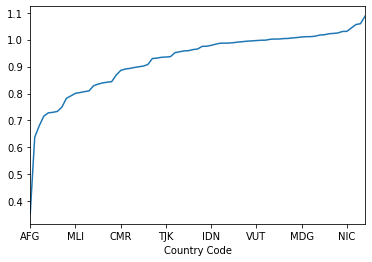

In [31]:
def agg_w_nan(s, func):
    s = s.dropna()
    if len(s)>=1:
        return s.agg(func)
    else:
        return np.nan

df.groupby('Country Code').f_to_m_enrollment.apply(lambda x: agg_w_nan(x, 'mean')).dropna().sort_values().plot()

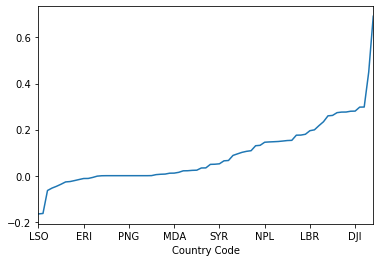

In [32]:
def s_chg(s):
    s = s.values
    return s[-1]-s[0]

df.groupby('Country Code').f_to_m_enrollment.apply(lambda x: agg_w_nan(x, s_chg)).dropna().sort_values().plot()


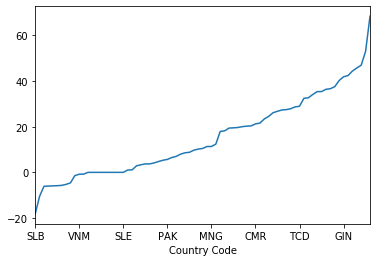

In [33]:
df.groupby('Country Code')['SE.PRM.TENR'].apply(lambda x: agg_w_nan(x, s_chg)).dropna().sort_values().plot()



In [34]:
gini_chg = df.groupby('Country Code')['SI.POV.GINI'].apply(lambda x: agg_w_nan(x, s_chg)).dropna()
gdp_chg = df.groupby('Country Code')['NY.GDP.PCAP.CD'].apply(lambda x: agg_w_nan(x, s_chg)).dropna()



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


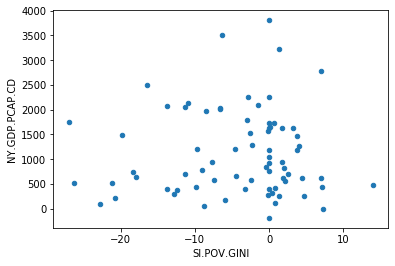

In [35]:
both = pd.concat([gini_chg, gdp_chg], axis=1).dropna()
both['country'] = both.index
both[both.country != 'USA'].plot.scatter(x = 'SI.POV.GINI', y='NY.GDP.PCAP.CD')